# Constellation and Chain Analysis: Multi Domain and Multi Hop

<img src="MultiDomain.jpg" alt="Drawing" style="width: 800px;"/>

**Terminology**
* Node = Object in STK
* Edge = Access between two objects in STK
* Strand = The sequence of nodes and edges to complete access in a chain

**This notebook shows how to:**
* Find the shortest path in a constellation, by specifying a starting constellation, an ending constellation and a connecting constellation. A second connecting constellation can also be optionally specified to allow multiple hops between two constellations, such as between receivers and transmitters.
* Typical STK constraints such as range, link duration, Eb/No, etc can be taken into account
* Load minimum signal transit time or minimum distance route and data strands back into STK
* Perform other network metrics such as minimum number of nodes to have a partial or complete network outage


In [22]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 70)
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.utilities.colors import Colors
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
import seaborn as sns
import matplotlib.pyplot as plt
from chainPathLib2 import *
import time
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

## Chain Names, Computation Time and Metric

In [23]:
# Inputs for Chain Analysis
startingConstellation = 'Targets' # Will be used as the start of the chain
firstConnectingConstellation = 'Observers' # Will be used to connect the the starting and ending constellation
secondConnectingConstellation = '' # Leave empty to just use one constellation
endingConstellation = 'GroundStations' # Will be used as the end of the chain

start = 0 # EpSec
stop = 3600*1 # EpSec
metric = 'timeDelay' # 'distance' or 'timeDelay'
nodeDelays = {'LEOs':0.01,'GEOs':0.005,'Aircraft':0.001} # Add in time delays. Provide the constellation name in STK and the node delays
stkVersion = 12

In [24]:
# Connect to STK
stkApp = STKDesktop.AttachToApplication()
stkRoot = stkApp.Root
stkRoot.UnitPreferences.SetCurrentUnit('DateFormat','EpSec')
stkRoot.ExecuteCommand('Units_SetConnect / Date "EpochSeconds"')
stkRoot.ExecuteCommand('VO * ObjectLine DeleteAll'); # Clean up old object lines

# Build chains and create a dict of time delays for each node
if not secondConnectingConstellation:
    chainNames = createChains(stkRoot,startingConstellation,firstConnectingConstellation,endingConstellation, color=Colors.FromRGB(0, 196, 196))
else:
    chainNames = createChains(stkRoot,startingConstellation,firstConnectingConstellation,endingConstellation,secondConnectingConstellation=secondConnectingConstellation, color=Colors.FromRGB(0, 196, 196))
nodeDelaysByNode = getNodeDelaysByNode(stkRoot,nodeDelays,chainNames=chainNames)

## Compute  Strands and Distances

In [25]:
chainNames

['StartingToConnecting', 'ConnectingToConnecting', 'ConnectingToEnding']

In [26]:
# Compute strands
t1 = time.time()
strands,dfStrands = getAllStrands(stkRoot,chainNames,start,stop)
print(time.time()-t1)
dfStrands

Loaded StartingToConnecting.pkl
Loaded ConnectingToConnecting.pkl
Loaded ConnectingToEnding.pkl
0.00500035285949707


,strand,start,stop,dur,num hops
25,"(Target/Target2, Satellite/LEO51)",0.000000,2.652854,2.652854,0.0
243,"(Satellite/LEO22, Satellite/LEO63)",0.000000,23.569712,23.569712,0.0
294,"(Satellite/LEO25, Satellite/LEO66)",0.000000,23.569712,23.569712,0.0
688,"(Satellite/LEO63, Satellite/LEO22)",0.000000,23.573265,23.573265,0.0
740,"(Satellite/LEO66, Satellite/LEO25)",0.000000,23.573265,23.573265,0.0
...,...,...,...,...,...
215,"(Satellite/LEO21, Satellite/LEO36)",3523.725759,3600.000000,76.274241,0.0
266,"(Satellite/LEO24, Satellite/LEO33)",3523.725759,3600.000000,76.274241,0.0
357,"(Satellite/LEO33, Satellite/LEO24)",3523.748921,3600.000000,76.251079,0.0
411,"(Satellite/LEO36, Satellite/LEO21)",3523.748921,3600.000000,76.251079,0.0


In [27]:
# Compute node positions, distances and time delays

# Time resolution of distance computation
step = 10 # sec

t1 = time.time()
nodesTimesPos = computeNodesPosOverTime(stkRoot,strands,start,stop,step) # Pull node position over time
t2 = time.time()
print(t2-t1)

t1 = time.time()
strandsAtTimes = getStrandsAtTimes(strands,start,stop,step) # Discretize strand intervals into times
t2 = time.time()
print(t2-t1)

t1 = time.time()
timeNodePos = computeTimeNodePos(strandsAtTimes,nodesTimesPos) # Nodes and positions at each time
t2 = time.time()
print(t2-t1)

t1 = time.time()
timesEdgesDistancesDelays = computeTimeEdgesDistancesDelays(strandsAtTimes,nodesTimesPos,nodeDelaysByNode)  # Edges, distances and delays at each time
t2 = time.time()
print(t2-t1)

0.01296234130859375
0.021998882293701172
0.02899932861328125
0.27001428604125977


## Use NX for Network Metrics and Reliability Analysis


In [28]:
# Get starting nodes and ending nodes from the constellations
startingNodes = getNodesFromConstellation(stkRoot,startingConstellation)
endingNodes = getNodesFromConstellation(stkRoot,endingConstellation)
startingNodes,endingNodes

(['Target/Target1',
  'Target/Target2',
  'Target/Target3',
  'Target/Target4',
  'Target/Target5',
  'Missile/Missile1'],
 ['Facility/Facility1', 'Facility/Facility2', 'Facility/Facility3'])

In [29]:
# Build new network at each time and gather metrics
t1 = time.time()

strandsShort = []
distances = []
timeStrandMetric = []
i = 0
setsOfMinNodesToRemoveAll = []
setsOfMinNodesToRemoveAny = []
for t in np.arange(start,stop+step,step):
    # Generate Network at each time
    if secondConnectingConstellation:
        G = generateDiNetwork(t,timesEdgesDistancesDelays,timeNodePos) # Build a directed network if two constellations are used
    else:
        G = generateNetwork(t,timesEdgesDistancesDelays,timeNodePos)

    # Find shortest strand metric
    if any([node in G.nodes() for node in startingNodes]) and any([node in G.nodes() for node in endingNodes]):
        strandShort,metricVal = shortestStrandDistance(G,startingNodes,endingNodes,metric=metric)
        timeStrandMetric.append((t,strandShort,metricVal))
    else:
        timeStrandMetric.append((t,'',np.nan))

    # Min nodes to remove to lose access to all starting and ending nodes. This takes awhile to compute
    setsOfMinNodesToRemoveAll.append(nodesToLoseAccess(G,startingNodes,endingNodes,loseAccessTo='all',topN=20))

    # Min nodes to remove to lose access to any starting or ending node. This takes awhile to compute
    setsOfMinNodesToRemoveAny.append(nodesToLoseAccess(G,startingNodes,endingNodes,loseAccessTo='any'))

df = pd.DataFrame(timeStrandMetric,columns=['time','strand',metric])
df['num hops'] = df['strand'].apply(lambda x: len(x)-2)
df.loc[df['num hops'] < 0,'num hops'] = np.nan
df[metric] = df[metric].astype(float)
if setsOfMinNodesToRemoveAny:
    numSets = [len(sets) for sets in setsOfMinNodesToRemoveAll]
    lengthOfSet = [len(sets[0]) if len(sets) > 0 else 0 for sets in setsOfMinNodesToRemoveAll]
    df['min nodes to lose access to all'] = lengthOfSet
    df['num of sets to lose access to all'] = numSets
if setsOfMinNodesToRemoveAny:
    numSets = [len(sets) for sets in setsOfMinNodesToRemoveAny]
    lengthOfSet = [len(sets[0]) if len(sets) > 0 else 0 for sets in setsOfMinNodesToRemoveAny]
    df['min nodes to lose access to any'] = lengthOfSet
    df['num of sets to lose access to any'] = numSets
time.time()-t1

13.058046579360962

<AxesSubplot:xlabel='time'>

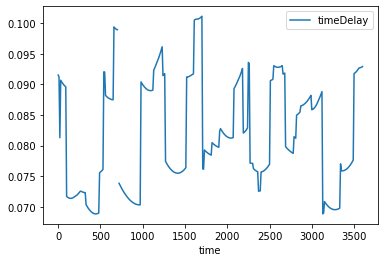

In [30]:
# Plot metric over time
df.plot.line(x='time',y=metric)

<AxesSubplot:xlabel='time'>

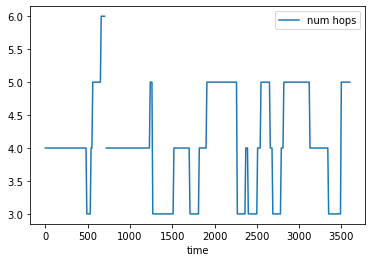

In [31]:
# Plot num hops
df.plot.line(x='time',y='num hops')

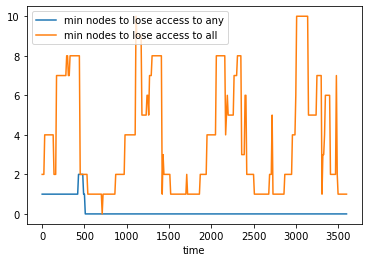

In [32]:
# Number of Nodes which must be removed to lose access to ANY of the starting and ending constellation
# And number of nodes to remove along the shortest path to lose access to ALL
if setsOfMinNodesToRemoveAny and setsOfMinNodesToRemoveAll:
    df.plot.line(x='time',y=['min nodes to lose access to any','min nodes to lose access to all'])

In [33]:
# Create intervals for the strands and add to STK
dfIntervals = createDfIntervals(df,stop,step)
addStrandsAsObjectLines(stkRoot,dfIntervals,color='yellow')

## Example Scenario and Metrics

In [34]:
# Most frequnt nodes in the shortest path
countNodesOverTime(df['strand'],topN=10)

array([['Facility/Facility1', '268'],
       ['Target/Target5', '161'],
       ['Target/Target1', '133'],
       ['Aircraft/Aircraft1', '128'],
       ['Satellite/LEO41', '82'],
       ['Aircraft/Aircraft2', '82'],
       ['Facility/Facility2', '79'],
       ['Satellite/LEO55', '76'],
       ['Satellite/LEO46', '75'],
       ['Satellite/LEO26', '73']], dtype='<U18')

In [35]:
# Most frequnt node in the shortest path and the sum of their durations
strands = dfIntervals[['strand','start','stop']].values
dfNodesIntervals = getNodesIntervalsFromStrands(strands)
dfNodeActive = getActiveDuration(dfNodesIntervals,start,stop)
dfNodeActive.sort_values('sum dur',ascending=False).head(10)

,sum dur,% time active
node,,
Facility/Facility1,2675.0,74.305556
Target/Target5,1600.0,44.444444
Target/Target1,1330.0,36.944444
Aircraft/Aircraft1,1275.0,35.416667
Satellite/LEO41,820.0,22.777778
Aircraft/Aircraft2,820.0,22.777778
Facility/Facility2,785.0,21.805556
Satellite/LEO55,760.0,21.111111
Satellite/LEO46,750.0,20.833333


In [36]:
# Sets of nodes to remove to lose All access
countNodesOverTime(setsOfMinNodesToRemoveAll,topN=5)

array([[('Satellite/LEO26',), 19],
       [('Satellite/LEO25',), 18],
       [('Satellite/LEO21',), 17],
       [('Satellite/LEO66',), 15],
       [('Satellite/LEO61',), 15]], dtype=object)

In [37]:
# Example of removing nodes
t=300
nodesToRemove = setsOfMinNodesToRemoveAll[int(t/step)][0][1:] # Remove all but 1
G = generateNetwork(t,timesEdgesDistancesDelays,timeNodePos)
nodesToRemove

('Satellite/LEO12',
 'Satellite/GEO',
 'Satellite/LEO61',
 'Satellite/LEO52',
 'Satellite/LEO22',
 'Satellite/LEO32',
 'Satellite/LEO62')

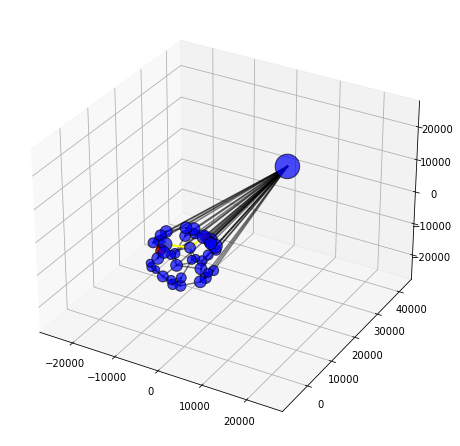

In [38]:
# Plot nodes based on position, red is stationary, blue is moving, the larger circles indicates more accesses
network_plot_3D(G,startingNodes=startingNodes,endingNodes=endingNodes)

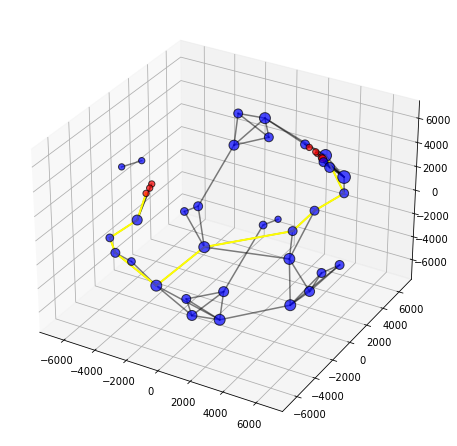

(['Missile/Missile1',
  'Satellite/LEO56',
  'Satellite/LEO24',
  'Satellite/LEO65',
  'Satellite/LEO25',
  'Satellite/LEO35',
  'Satellite/LEO26',
  'Satellite/LEO53',
  'Satellite/LEO21',
  'Facility/Facility3'],
 '0.1852551862973685')

In [39]:
# New path with nodes removed
G2 = G.copy()
G2.remove_nodes_from(nodesToRemove)
network_plot_3D(G2,startingNodes=startingNodes,endingNodes=endingNodes)
strandShort,metricVal = shortestStrandDistance(G2,startingNodes,endingNodes,metric=metric)
strandShort,metricVal

In [40]:
# Look at network when there is a gap
df.loc[df['min nodes to lose access to all'] == 0]

,time,strand,timeDelay,num hops,min nodes to lose access to all,num of sets to lose access to all,min nodes to lose access to any,num of sets to lose access to any
71,710,,NaN,NaN,0,0,0,0


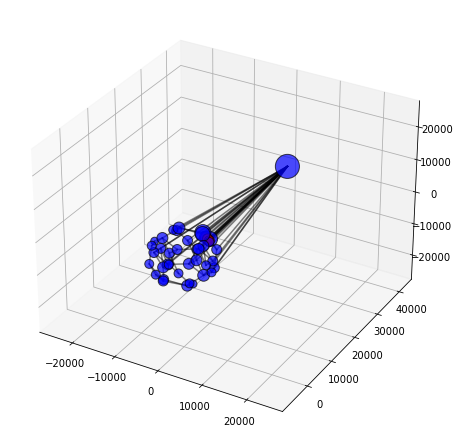

In [41]:
# No valid paths
t=710
G = generateNetwork(t,timesEdgesDistancesDelays,timeNodePos)
network_plot_3D(G,startingNodes=startingNodes,endingNodes=endingNodes)

In [42]:
# Add data back into STK
t1 = time.time()
addDataToSTK(stkRoot,chainNames[0],df) # Adds data in df back into STK to the first chain under User Supplied data
print(time.time()-t1)

0.5600512027740479
